# Fourier Reconstruction - Instagram Reel
**Conveyor belt visualization of frequency combination**

In [51]:
# !pip install librosa numpy matplotlib moviepy soundfile

In [52]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from moviepy import VideoClip, AudioFileClip
import soundfile as sf
import os
import tempfile

## Load Audio & FFT

In [53]:
audio_path = "FAHHH.mp3"
y, sr = librosa.load(audio_path, sr=22050)
audio_duration = len(y) / sr

# Normalize
y = y / np.max(np.abs(y))

print(f"Duration: {audio_duration:.2f}s, Sample rate: {sr}Hz")

Duration: 1.47s, Sample rate: 22050Hz


In [54]:
# FFT
fft_result = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(y), 1/sr)
magnitudes = np.abs(fft_result)

# Sort by magnitude (most important first) - these are our "frequency indices"
sorted_indices = np.argsort(magnitudes)[::-1]

# Normalize magnitudes for display
max_mag = np.max(magnitudes)
norm_magnitudes = magnitudes / max_mag

print(f"Total frequency components: {len(frequencies)//2}")

Total frequency components: 16229


In [55]:
def reconstruct(n):
    """Reconstruct audio with top n frequencies."""
    if n == 0:
        return np.zeros_like(y)
    reconstructed_fft = np.zeros_like(fft_result)
    reconstructed_fft[sorted_indices[:n]] = fft_result[sorted_indices[:n]]
    signal = np.fft.ifft(reconstructed_fft).real
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val * 0.95
    return signal.astype(np.float32)

def generate_sine(freq_idx, t_array):
    """Generate sine wave for the freq_idx-th most important frequency."""
    idx = sorted_indices[freq_idx]
    freq = frequencies[idx]
    amp = norm_magnitudes[idx]
    phase = np.angle(fft_result[idx])
    return amp * np.cos(2 * np.pi * freq * t_array + phase)

## Animation Configuration

In [56]:
# Instagram Reel: 1080x1920 (9:16)
WIDTH, HEIGHT = 1080, 1920
DPI = 100
FIG_WIDTH = WIDTH / DPI
FIG_HEIGHT = HEIGHT / DPI
FPS = 30

# Colors
BG_COLOR = '#0d1117'
ORIGINAL_COLOR = '#58a6ff'
COMBINED_COLOR = '#f78166'
BELT_COLORS = plt.cm.viridis(np.linspace(0.3, 0.9, 100))

# Milestones: cumulative frequency counts
# We combine: 5, then 5 more (=10), then 15 more (=25), then 25 more (=50), etc.
milestones = [5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000]
max_freqs = len(fft_result) // 2
milestones = [n for n in milestones if n <= max_freqs]

# Timing
INTRO_DURATION = 1.5           # Show original waveform
ORIGINAL_PLAY = audio_duration + 0.3
COMBINE_DURATION = 2.0         # Fixed 2 seconds for all combine animations
PLAY_DURATION = audio_duration + 0.3

# Build timeline
timeline = []
t = 0

# Intro
timeline.append(('intro', t, t + INTRO_DURATION, 0, 0))
t += INTRO_DURATION

# Play original
timeline.append(('play_original', t, t + ORIGINAL_PLAY, 0, 0))
t += ORIGINAL_PLAY

# Combine and play for each milestone
prev_n = 0
for n in milestones:
    timeline.append(('combine', t, t + COMBINE_DURATION, prev_n, n))
    t += COMBINE_DURATION
    timeline.append(('play', t, t + PLAY_DURATION, n, n))
    t += PLAY_DURATION
    prev_n = n

total_duration = t
print(f"Timeline: {len(timeline)} phases")
print(f"Total duration: {total_duration:.1f}s")
for phase in timeline:
    print(f"  {phase[0]:15} {phase[1]:6.1f}s - {phase[2]:6.1f}s  (n: {phase[3]} -> {phase[4]})")

Timeline: 22 phases
Total duration: 41.0s
  intro              0.0s -    1.5s  (n: 0 -> 0)
  play_original      1.5s -    3.3s  (n: 0 -> 0)
  combine            3.3s -    5.3s  (n: 0 -> 5)
  play               5.3s -    7.0s  (n: 5 -> 5)
  combine            7.0s -    9.0s  (n: 5 -> 10)
  play               9.0s -   10.8s  (n: 10 -> 10)
  combine           10.8s -   12.8s  (n: 10 -> 25)
  play              12.8s -   14.6s  (n: 25 -> 25)
  combine           14.6s -   16.6s  (n: 25 -> 50)
  play              16.6s -   18.4s  (n: 50 -> 50)
  combine           18.4s -   20.4s  (n: 50 -> 100)
  play              20.4s -   22.1s  (n: 100 -> 100)
  combine           22.1s -   24.1s  (n: 100 -> 250)
  play              24.1s -   25.9s  (n: 250 -> 250)
  combine           25.9s -   27.9s  (n: 250 -> 500)
  play              27.9s -   29.7s  (n: 500 -> 500)
  combine           29.7s -   31.7s  (n: 500 -> 1000)
  play              31.7s -   33.4s  (n: 1000 -> 1000)
  combine           33.4s -   3

## Build Audio Track

In [57]:
temp_dir = tempfile.mkdtemp()
audio_segments = []

for phase_name, start, end, n_start, n_end in timeline:
    duration = end - start
    samples = int(duration * sr)
    
    if phase_name == 'play_original':
        # Play original audio
        audio_segments.append(y[:int(audio_duration * sr)].astype(np.float32))
        audio_segments.append(np.zeros(int(0.3 * sr), dtype=np.float32))
    elif phase_name == 'play':
        # Play reconstructed audio
        recon = reconstruct(n_end)
        audio_segments.append(recon[:int(audio_duration * sr)])
        audio_segments.append(np.zeros(int(0.3 * sr), dtype=np.float32))
    else:
        # Silence during intro and combine phases
        audio_segments.append(np.zeros(samples, dtype=np.float32))

full_audio = np.concatenate(audio_segments)
audio_path_out = os.path.join(temp_dir, "audio.wav")
sf.write(audio_path_out, full_audio, sr)

print(f"Audio track: {len(full_audio)/sr:.1f}s (expected: {total_duration:.1f}s)")

Audio track: 41.0s (expected: 41.0s)


## Frame Rendering

In [58]:
# Precompute
display_duration = 0.025  # 25ms window for waveforms
display_samples = int(display_duration * sr)
t_wave = np.linspace(0, display_duration, display_samples)

# Precompute reconstructions
print("Precomputing reconstructions...")
reconstructions = {0: np.zeros_like(y)}
for n in milestones:
    reconstructions[n] = reconstruct(n)
    print(f"  {n} frequencies")

# Precompute sine waves for first N frequencies (for belt display)
MAX_BELT_DISPLAY = 100  # Max frequencies to show on belt at once
VISIBLE_ON_BELT = 12    # How many sine waves visible at a time

print("Precomputing sine waves...")
sine_waves = {}
for i in range(min(max(milestones) + 50, max_freqs)):
    sine_waves[i] = generate_sine(i, t_wave)
print(f"  {len(sine_waves)} sine waves cached")

Precomputing reconstructions...
  5 frequencies
  10 frequencies
  25 frequencies
  50 frequencies
  100 frequencies
  250 frequencies
  500 frequencies
  1000 frequencies
  2500 frequencies
  5000 frequencies
Precomputing sine waves...
  5050 sine waves cached


In [59]:
def get_phase_at_time(t):
    """Return (phase_name, progress, n_combined, n_target) at time t."""
    for phase_name, start, end, n_start, n_end in timeline:
        if start <= t < end:
            progress = (t - start) / (end - start)
            return phase_name, progress, n_start, n_end
    # Past end
    return timeline[-1][0], 1.0, timeline[-1][3], timeline[-1][4]

def ease_out_cubic(t):
    return 1 - (1 - t) ** 3

def ease_in_out_quad(t):
    return 2 * t * t if t < 0.5 else 1 - (-2 * t + 2) ** 2 / 2

In [60]:
def make_frame(t):
    phase, progress, n_start, n_target = get_phase_at_time(t)
    
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=DPI)
    fig.patch.set_facecolor(BG_COLOR)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_facecolor(BG_COLOR)
    ax.axis('off')
    
    # Layout - title at very top, then waveforms below
    X_PAD = 0.12
    WAVE_HEIGHT = 0.05
    TITLE_Y = 0.96
    ORIGINAL_Y = 0.80
    COMBINED_Y = 0.65
    BELT_TOP = 0.55
    BELT_BOTTOM = 0.05
    BELT_SPACING = (BELT_TOP - BELT_BOTTOM) / VISIBLE_ON_BELT
    
    x_range = np.linspace(X_PAD, 1 - X_PAD, display_samples)
    
    # === TITLE (at very top) ===
    ax.text(0.5, TITLE_Y, "Fourier Reconstruction", color='white',
            fontsize=40, ha='center', va='top', fontweight='bold')
    ax.text(0.5, TITLE_Y - 0.04, "Frequencies sorted by magnitude (strongest first)", 
            color='#8b949e', fontsize=24, ha='center', va='top', style='italic')
    
    # Playback position
    if phase in ['play_original', 'play']:
        play_pos = int(progress * (len(y) - display_samples))
    else:
        play_pos = 0
    
    # === ORIGINAL WAVEFORM ===
    orig_slice = y[play_pos:play_pos + display_samples]
    orig_y = ORIGINAL_Y + orig_slice * WAVE_HEIGHT
    ax.plot(x_range, orig_y, color=ORIGINAL_COLOR, linewidth=2.5, alpha=1.0)
    
    label = "Original" if phase not in ['intro', 'play_original'] else "Original" if phase == 'play_original' else "Original"
    ax.text(0.5, ORIGINAL_Y + WAVE_HEIGHT + 0.015, label, color='white', 
            fontsize=24, ha='center', va='bottom', fontweight='bold')
    
    # === COMBINED WAVEFORM ===
    if phase == 'combine':
        # During combine: interpolate between n_start and n_target
        eased = ease_out_cubic(progress)
        n_current = int(n_start + (n_target - n_start) * eased)
        n_current = max(1, n_current)
        
        # Get combined waveform (reconstruct on the fly or interpolate)
        if n_current in reconstructions:
            combined = reconstructions[n_current]
        else:
            combined = reconstruct(n_current)
        
        combined_slice = combined[play_pos:play_pos + display_samples]
        max_c = np.max(np.abs(combined))
        if max_c > 0:
            combined_slice = combined_slice / max_c
        combined_y = COMBINED_Y + combined_slice * WAVE_HEIGHT
        ax.plot(x_range, combined_y, color=COMBINED_COLOR, linewidth=2.5, alpha=0.9)
        ax.text(0.5, COMBINED_Y + WAVE_HEIGHT + 0.02, f"Top {n_current} frequencies", 
                color=COMBINED_COLOR, fontsize=24, ha='center', va='bottom', fontweight='bold')
        
    elif phase == 'play' and n_target > 0:
        combined = reconstructions[n_target]
        combined_slice = combined[play_pos:play_pos + display_samples]
        max_c = np.max(np.abs(combined))
        if max_c > 0:
            combined_slice = combined_slice / max_c
        combined_y = COMBINED_Y + combined_slice * WAVE_HEIGHT
        ax.plot(x_range, combined_y, color=COMBINED_COLOR, linewidth=2.5, alpha=1.0)
        ax.text(0.5, COMBINED_Y + WAVE_HEIGHT + 0.02, f"Top {n_target} frequencies", 
                color=COMBINED_COLOR, fontsize=24, ha='center', va='bottom', fontweight='bold')
    
    elif phase not in ['intro', 'play_original']:
        # Show flat line or previous combined
        if n_start > 0:
            combined = reconstructions.get(n_start, np.zeros_like(y))
            combined_slice = combined[play_pos:play_pos + display_samples]
            max_c = np.max(np.abs(combined))
            if max_c > 0:
                combined_slice = combined_slice / max_c
            combined_y = COMBINED_Y + combined_slice * WAVE_HEIGHT
            ax.plot(x_range, combined_y, color=COMBINED_COLOR, linewidth=2.5, alpha=0.7)
            ax.text(0.5, COMBINED_Y + WAVE_HEIGHT + 0.02, f"{n_start} frequencies", 
                    color=COMBINED_COLOR, fontsize=16, ha='center', va='bottom', alpha=0.7)
    
    # === CONVEYOR BELT OF FREQUENCIES ===
    if phase == 'combine':
        eased = ease_out_cubic(progress)
        n_current = int(n_start + (n_target - n_start) * eased)
        
        # Belt offset: frequencies scroll up as they get combined
        # The "top" of the belt is at n_current, frequencies below scroll up
        belt_offset = (n_current - n_start) * BELT_SPACING * 0.3  # Scroll amount
        
        # Show frequencies from n_current to n_current + VISIBLE_ON_BELT
        for i in range(VISIBLE_ON_BELT + 3):
            freq_idx = n_current + i
            if freq_idx >= len(sine_waves) or freq_idx >= n_target + VISIBLE_ON_BELT:
                break
            
            # Y position: top of belt, scrolling down
            base_y = BELT_TOP - i * BELT_SPACING
            
            # Frequencies being absorbed animate upward
            if freq_idx < n_current:
                # Already combined - fade out going up
                absorption = (n_current - freq_idx) / max(1, n_target - n_start) * 5
                base_y = BELT_TOP + absorption * 0.1
                alpha = max(0, 0.4 - absorption * 0.3)
            elif freq_idx == n_current:
                # Currently being absorbed
                alpha = 0.8
                # Animate toward combined waveform
                frac = (eased * (n_target - n_start)) % 1
                base_y = BELT_TOP + frac * (COMBINED_Y - BELT_TOP) * 0.3
            else:
                # Waiting on belt
                dist_from_top = freq_idx - n_current
                alpha = max(0.7, 1.0 - dist_from_top * 0.04)
            
            if base_y < BELT_BOTTOM - 0.05 or base_y > BELT_TOP + 0.1:
                continue
            
            # Get sine wave
            if freq_idx in sine_waves:
                sine = sine_waves[freq_idx]
            else:
                continue
            
            # Scale by relative magnitude
            mag = norm_magnitudes[sorted_indices[freq_idx]]
            scale = 0.3 + mag * 0.7  # Scale between 0.3 and 1.0
            
            sine_y = base_y + sine * WAVE_HEIGHT * 0.5 * scale
            
            color_idx = freq_idx % len(BELT_COLORS)
            ax.plot(x_range, sine_y, color=BELT_COLORS[color_idx], 
                    linewidth=1.5, alpha=alpha)
            
            # Frequency index label
            ax.text(X_PAD - 0.02, base_y, f"{freq_idx + 1}", 
                    color='white', fontsize=18, ha='right', va='center', 
                    alpha=alpha * 0.9, fontweight='bold')
    
    elif phase == 'play' and n_target > 0:
        # Show frequencies waiting on belt (below current combined)
        for i in range(VISIBLE_ON_BELT):
            freq_idx = n_target + i
            if freq_idx >= len(sine_waves):
                break
            
            base_y = BELT_TOP - i * BELT_SPACING
            alpha = max(0.15, 0.5 - i * 0.03)
            
            sine = sine_waves[freq_idx]
            mag = norm_magnitudes[sorted_indices[freq_idx]]
            scale = 0.3 + mag * 0.7
            sine_y = base_y + sine * WAVE_HEIGHT * 0.5 * scale
            
            color_idx = freq_idx % len(BELT_COLORS)
            ax.plot(x_range, sine_y, color=BELT_COLORS[color_idx], 
                    linewidth=1.5, alpha=alpha)
            ax.text(X_PAD - 0.02, base_y, f"{freq_idx + 1}", 
                    color='white', fontsize=18, ha='right', va='center', 
                    alpha=alpha * 0.9, fontweight='bold')
    
    elif phase in ['intro', 'play_original']:
        # Show first frequencies waiting
        for i in range(VISIBLE_ON_BELT):
            if i >= len(sine_waves):
                break
            
            base_y = BELT_TOP - i * BELT_SPACING
            alpha = max(0.2, 0.6 - i * 0.03)
            
            sine = sine_waves[i]
            mag = norm_magnitudes[sorted_indices[i]]
            scale = 0.3 + mag * 0.7
            sine_y = base_y + sine * WAVE_HEIGHT * 0.5 * scale
            
            color_idx = i % len(BELT_COLORS)
            ax.plot(x_range, sine_y, color=BELT_COLORS[color_idx], 
                    linewidth=1.5, alpha=alpha)
            ax.text(X_PAD - 0.02, base_y, f"{i + 1}", 
                    color='white', fontsize=24, ha='right', va='center', 
                    alpha=alpha * 0.9, fontweight='bold')
    
    # === BELT ARROW / INDICATOR ===
    if phase == 'combine':
        # Arrow indicating direction
        ax.annotate('', xy=(0.5, COMBINED_Y - 0.05), xytext=(0.5, BELT_TOP + 0.02),
                    arrowprops=dict(arrowstyle= "->, head_width=1, head_length=1", color='white', alpha=0.5, lw=3))
    
    # === STATUS TEXT ===
    if phase == 'combine':
        n_current = int(n_start + (n_target - n_start) * ease_out_cubic(progress))
        ax.text(0.5, 0.02, f"Combining frequencies Upto index #{n_target}...", 
                color='white', fontsize=24, ha='center', va='bottom', fontweight='bold')
    
    # Convert to numpy array
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape((HEIGHT, WIDTH, 3))
    plt.close(fig)
    
    return frame

C:\Users\kaustav\AppData\Local\Temp\ipykernel_45420\1475631781.py:207: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


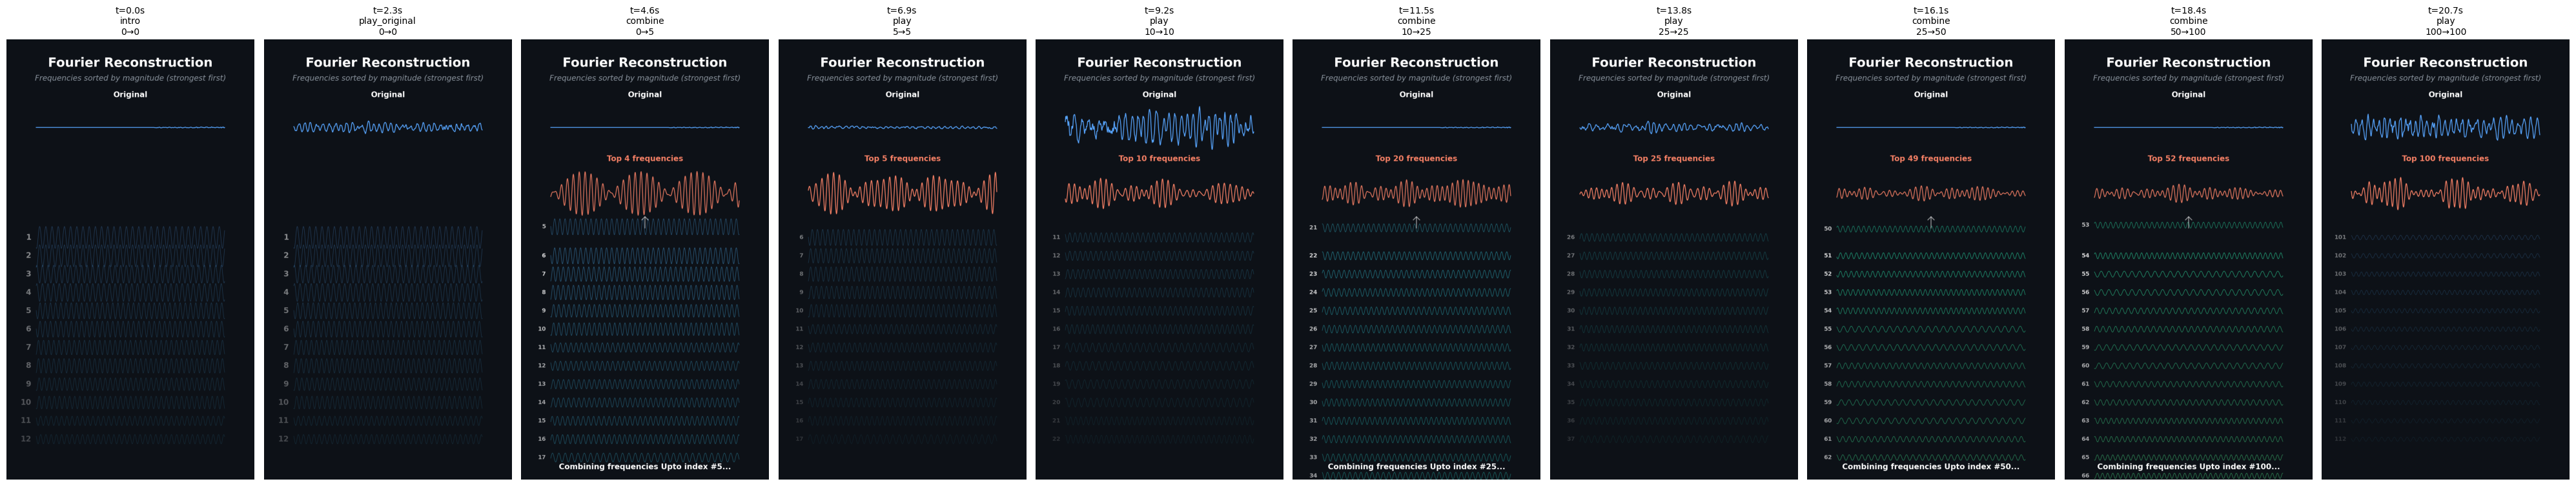

In [61]:
# Test frames
test_times = [2.3*i for i in range(10)]
test_times = [t for t in test_times if t < total_duration]

fig, axes = plt.subplots(1, len(test_times), figsize=(4 * len(test_times), 8))
if len(test_times) == 1:
    axes = [axes]

for ax, t in zip(axes, test_times):
    frame = make_frame(t)
    ax.imshow(frame)
    phase, prog, n_s, n_t = get_phase_at_time(t)
    ax.set_title(f"t={t:.1f}s\n{phase}\n{n_s}→{n_t}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Export MP4

In [62]:
print(f"Rendering {total_duration:.1f}s video at {FPS}fps...")
print(f"Resolution: {WIDTH}x{HEIGHT} (9:16)")
print("This will take several minutes...\n")

video_clip = VideoClip(make_frame, duration=total_duration)
audio_clip = AudioFileClip(audio_path_out)

# Trim audio if needed
if audio_clip.duration > total_duration:
    audio_clip = audio_clip.with_duration(total_duration)

final_clip = video_clip.with_audio(audio_clip)

output_path = "fourier_reel.mp4"
final_clip.write_videofile(
    output_path,
    fps=FPS,
    codec='libx264',
    audio_codec='aac',
    logger='bar'
)

video_clip.close()
audio_clip.close()
final_clip.close()

print(f"\n✅ Exported: {output_path}")

C:\Users\kaustav\AppData\Local\Temp\ipykernel_45420\1475631781.py:207: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Rendering 41.0s video at 30fps...
Resolution: 1080x1920 (9:16)
This will take several minutes...

MoviePy - Building video fourier_reel.mp4.
MoviePy - Writing audio in fourier_reelTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video fourier_reel.mp4



MoviePy - Done !
MoviePy - video ready fourier_reel.mp4

✅ Exported: fourier_reel.mp4


In [63]:
# Cleanup
import shutil
shutil.rmtree(temp_dir, ignore_errors=True)
print("Done!")

Done!
